In [27]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image, ImageEnhance, ImageOps
import joblib
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter

In [3]:
def load_operator_data(dataset_path='dataset'):
    IMG_SIZE = (28, 28)
    CLASSES = ['add', 'sub', 'mul', 'div']
    data = []
    labels = []
    
    for label, category in enumerate(CLASSES):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            print(f"Warning: Directory {category_path} not found!")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # retain RGB channels
                img = img.resize(IMG_SIZE)
                img_array = np.array(img).astype('float32') / 255.0
                data.append(img_array.flatten())
                labels.append(label)
                
    data = np.array(data)
    labels = np.array(labels)
    return data, labels, CLASSES

def load_mnist_from_csv(train_path, test_path):
    train_data = pd.read_csv(train_path)
    if train_data.isna().any().any():
        train_data = train_data.fillna(0)
    
    X_train = train_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_train = train_data.iloc[:, 0].values.astype(int)
    
    test_data = pd.read_csv(test_path)
    if test_data.isna().any().any():
        test_data = test_data.fillna(0)
    
    X_test = test_data.iloc[:, 1:].values.astype(np.float32) / 255.0
    y_test = test_data.iloc[:, 0].values.astype(int)
    
    return X_train, y_train, X_test, y_test

In [5]:
def visualize_digits(images, labels, num_samples=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [7]:
def train_evaluate_rfc(X_train, y_train, X_test, y_test, n_estimators):
    """
    Trains a Random Forest Classifier
    """
    clf = RandomForestClassifier(n_estimators, random_state=42)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    predict_time = time.time() - start_time
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Model training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"Accuracy: {acc * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, y_pred

--- Operator Model Training ---
Model training time: 1.32 seconds
Prediction time: 0.01 seconds
Accuracy: 95.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       122
           1       0.95      0.98      0.96       132
           2       0.96      0.97      0.96       122
           3       0.92      0.93      0.93       114

    accuracy                           0.95       490
   macro avg       0.95      0.95      0.95       490
weighted avg       0.95      0.95      0.95       490



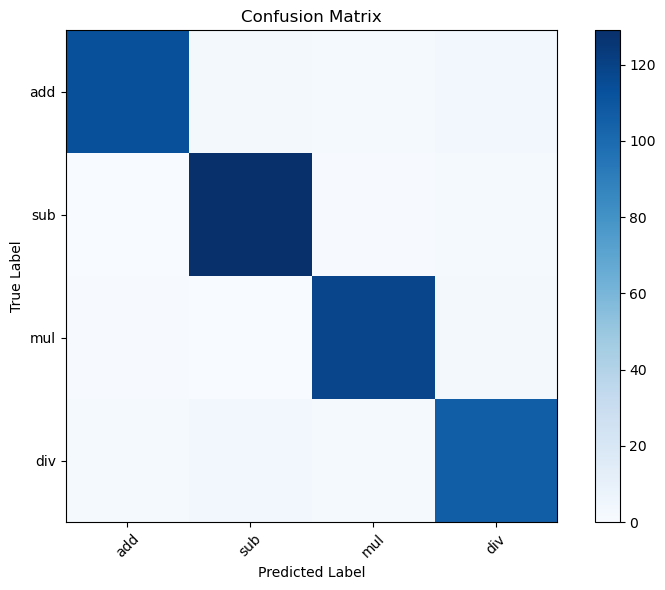

--- MNIST Digit Model Training ---
Displaying sample digits from MNIST:


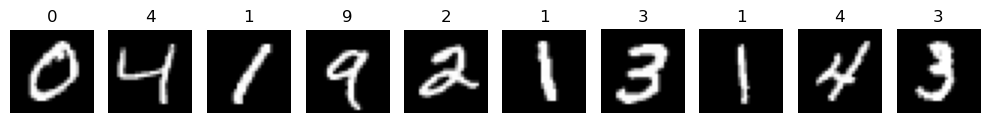

Model training time: 25.60 seconds
Prediction time: 0.15 seconds
Accuracy: 96.87%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1027
           8       0.96      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



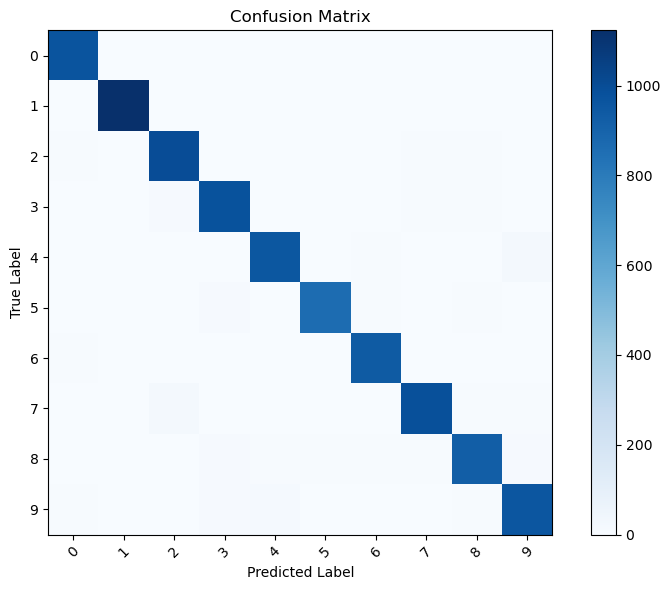

['digit_model.joblib']

In [9]:
print("--- Operator Model Training ---")
op_data, op_labels, op_classes = load_operator_data(dataset_path='dataset')

X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(
    op_data, op_labels, test_size=0.2, random_state=42)

operator_clf, op_y_pred = train_evaluate_rfc(X_train_op, y_train_op, X_test_op, y_test_op, 200)
plot_confusion_matrix(y_test_op, op_y_pred, classes=op_classes)

# Save operator model to avoid retraining every time
joblib.dump(operator_clf, 'operator_model.joblib')



print("--- MNIST Digit Model Training ---")
train_path = "mnist_train.csv"
test_path = "mnist_test.csv"

X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist = load_mnist_from_csv(train_path, test_path)

print("Displaying sample digits from MNIST:")
visualize_digits(X_train_mnist, y_train_mnist)

digit_clf, mnist_y_pred = train_evaluate_rfc(X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist, 100)
plot_confusion_matrix(y_test_mnist, mnist_y_pred, classes=[str(i) for i in range(10)])

# Save MNIST model
joblib.dump(digit_clf, 'digit_model.joblib')

In [11]:
def merge_boxes(boxes, threshold=12):
    merged = []
    used = [False] * len(boxes)
    for i in range(len(boxes)):
        if used[i]:
            continue
        x1, y1, w1, h1 = boxes[i]
        box_i = [x1, y1, x1 + w1, y1 + h1]
        for j in range(i + 1, len(boxes)):
            if used[j]:
                continue
            x2, y2, w2, h2 = boxes[j]
            box_j = [x2, y2, x2 + w2, y2 + h2]
            if abs(x1 - x2) < threshold or abs((x2 + w2) - (x1 + w1)) < threshold:
                if abs(y1 - y2) < 14:
                    new_x = min(box_i[0], box_j[0])
                    new_y = min(box_i[1], box_j[1])
                    new_x2 = max(box_i[2], box_j[2])
                    new_y2 = max(box_i[3], box_j[3])
                    box_i = [new_x, new_y, new_x2, new_y2]
                    used[j] = True
        used[i] = True
        merged.append((box_i[0], box_i[1], box_i[2] - box_i[0], box_i[3] - box_i[1]))
    return merged

In [13]:
def segment_expression(image_path):
    img = cv2.imread(image_path)
    img_copy = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = sorted(boxes, key=lambda b: b[0])
    merged_boxes = merge_boxes(boxes, threshold=15)
    segments = []
    for x, y, w, h in merged_boxes:
        char_img = gray[y:y+h, x:x+w]
        segments.append(char_img)
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
    return img_copy, segments

In [15]:
def preprocess_segment_for_digit(roi_gray):
    roi_gray = 255 - roi_gray
    _, roi_bin = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ys, xs = np.where(roi_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        return np.zeros((784,), dtype=np.float32)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    roi_cropped = roi_gray[y_min:y_max+1, x_min:x_max+1]
    h, w = roi_cropped.shape
    if h > w:
        new_h, new_w = 20, int(w * (20.0 / h))
    else:
        new_w, new_h = 20, int(h * (20.0 / w))
    roi_resized = cv2.resize(roi_cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((28, 28), dtype=np.uint8)
    x_offset = (28 - new_w) // 2
    y_offset = (28 - new_h) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = roi_resized
    canvas = canvas.astype(np.float32) / 255.0
    return canvas.flatten()

def preprocess_segment_for_operator(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(img_rgb, (28, 28)).astype('float32') / 255.0
    return resized.flatten()

In [17]:
def classify_segment(idx, roi_gray, digit_model, operator_model):
    digit_input = preprocess_segment_for_digit(roi_gray)
    operator_input = preprocess_segment_for_operator(roi_gray)

    if idx % 2 == 0:
        prediction = digit_model.predict([digit_input])[0]
        symbol = str(prediction)
    else:
        prediction = operator_model.predict([operator_input])[0]
        op_mapping = {0: '+', 1: '-', 2: '*', 3: '/'}
        symbol = op_mapping.get(prediction, '?')
    
    return symbol

In [29]:
def process_expression(image_path, digit_model, operator_model, debug=False, flag=False):
    boxed_img, segments = segment_expression(image_path)
    expression = ""
    if debug:
        plt.imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB))
        plt.title("Merged Segmentation Results")
        plt.axis('off')
        plt.show()
    for idx, roi in enumerate(segments):
        symbol = classify_segment(idx, roi, digit_model, operator_model)
        if not flag:
            print(f"Segment #{idx}: '{symbol}'")
        expression += symbol
    return expression


Processing image: expression_dataset/expr_083.png


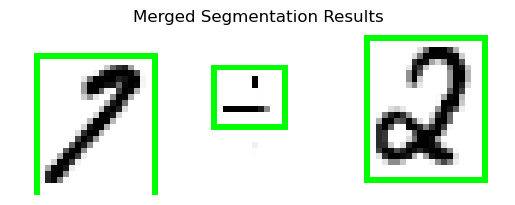

Segment #0: '2'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 2/2

Processing image: expression_dataset/expr_097.png


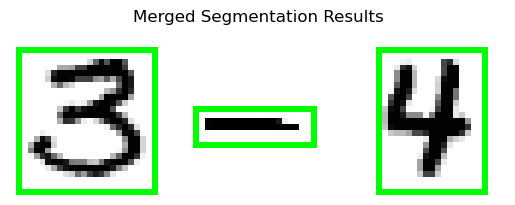

Segment #0: '3'
Segment #1: '/'
Segment #2: '4'
Reconstructed Expression: 3/4

Processing image: expression_dataset/expr_068.png


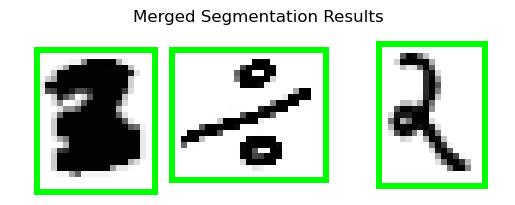

Segment #0: '8'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 8/2

Processing image: expression_dataset/expr_040.png


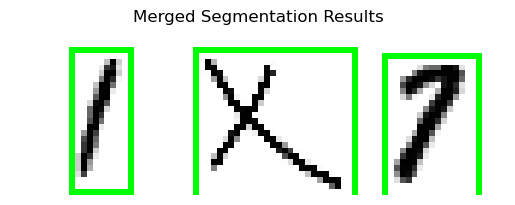

Segment #0: '1'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 1*2

Processing image: expression_dataset/expr_054.png


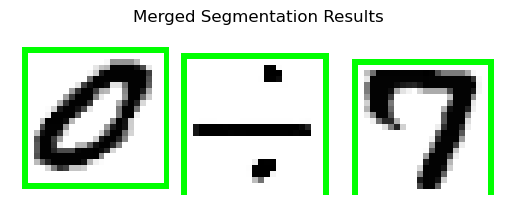

Segment #0: '0'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 0/2

Processing image: expression_dataset/expr_055.png


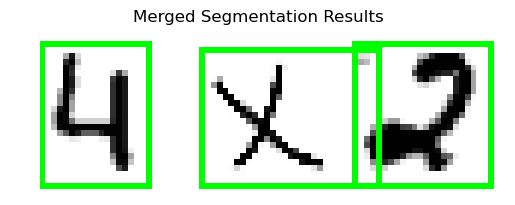

Segment #0: '4'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 4/2

Processing image: expression_dataset/expr_041.png


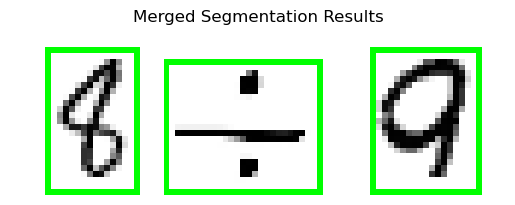

Segment #0: '8'
Segment #1: '/'
Segment #2: '9'
Reconstructed Expression: 8/9

Processing image: expression_dataset/expr_069.png


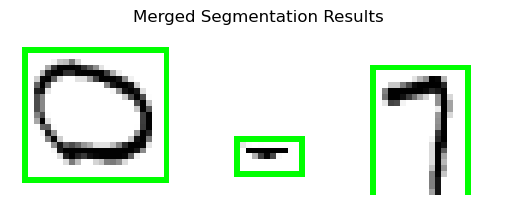

Segment #0: '0'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 0*2

Processing image: expression_dataset/expr_096.png


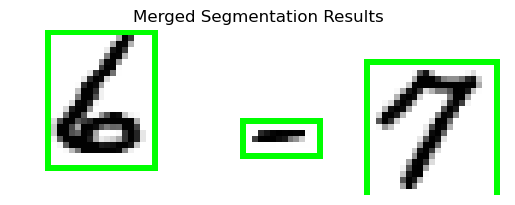

Segment #0: '6'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 6+2

Processing image: expression_dataset/expr_082.png


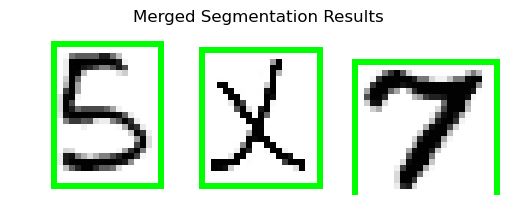

Segment #0: '5'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 5*2

Processing image: expression_dataset/expr_094.png


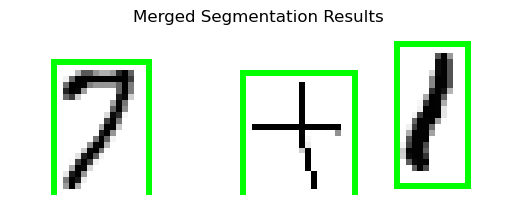

Segment #0: '2'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 2+1

Processing image: expression_dataset/expr_080.png


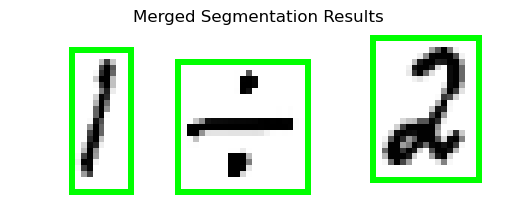

Segment #0: '1'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 1/2

Processing image: expression_dataset/expr_057.png


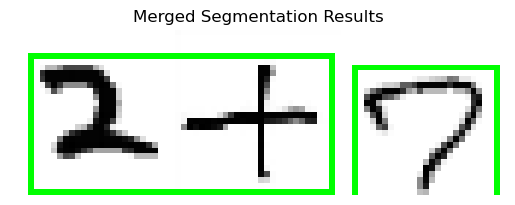

Segment #0: '4'
Segment #1: '/'
Reconstructed Expression: 4/

Processing image: expression_dataset/expr_043.png


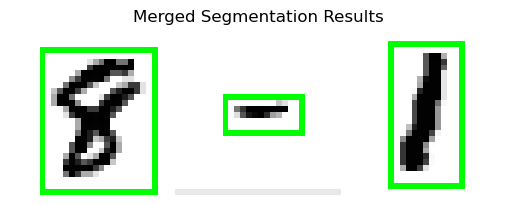

Segment #0: '8'
Segment #1: '/'
Segment #2: '1'
Reconstructed Expression: 8/1

Processing image: expression_dataset/expr_042.png


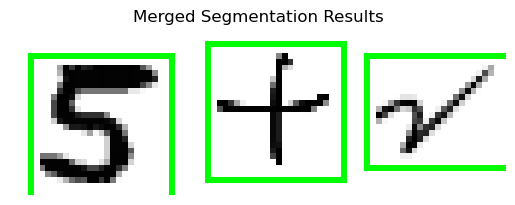

Segment #0: '5'
Segment #1: '+'
Segment #2: '4'
Reconstructed Expression: 5+4

Processing image: expression_dataset/expr_056.png


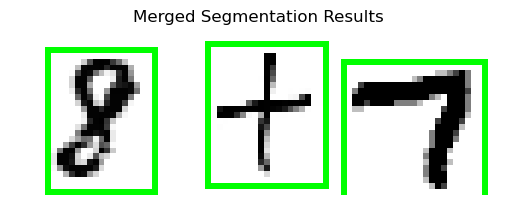

Segment #0: '8'
Segment #1: '+'
Segment #2: '0'
Reconstructed Expression: 8+0

Processing image: expression_dataset/expr_081.png


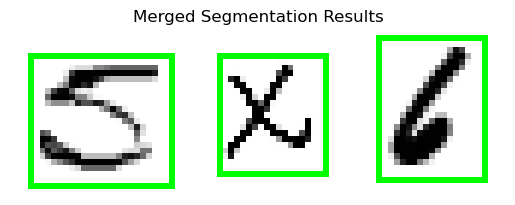

Segment #0: '5'
Segment #1: '*'
Segment #2: '6'
Reconstructed Expression: 5*6

Processing image: expression_dataset/expr_095.png


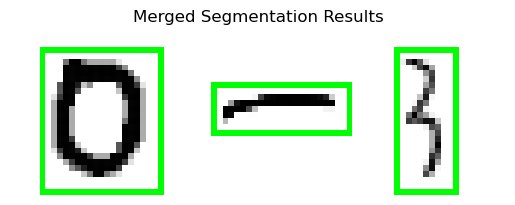

Segment #0: '0'
Segment #1: '+'
Segment #2: '3'
Reconstructed Expression: 0+3

Processing image: expression_dataset/expr_091.png


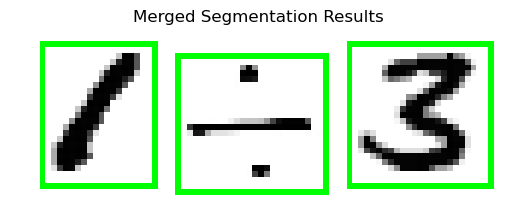

Segment #0: '1'
Segment #1: '/'
Segment #2: '3'
Reconstructed Expression: 1/3

Processing image: expression_dataset/expr_085.png


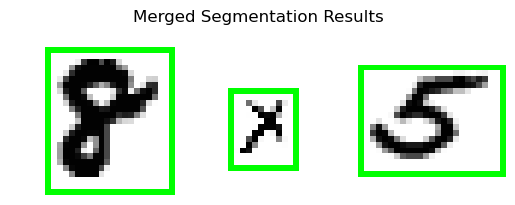

Segment #0: '8'
Segment #1: '*'
Segment #2: '5'
Reconstructed Expression: 8*5

Processing image: expression_dataset/expr_052.png


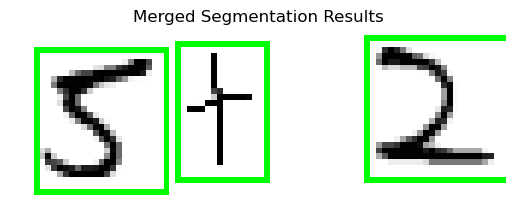

Segment #0: '5'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 5+2

Processing image: expression_dataset/expr_046.png


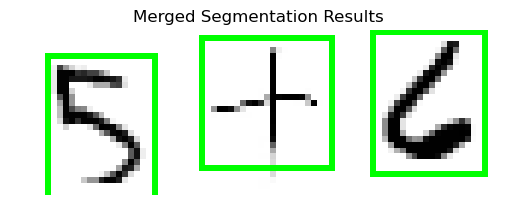

Segment #0: '5'
Segment #1: '+'
Segment #2: '0'
Reconstructed Expression: 5+0

Processing image: expression_dataset/expr_047.png


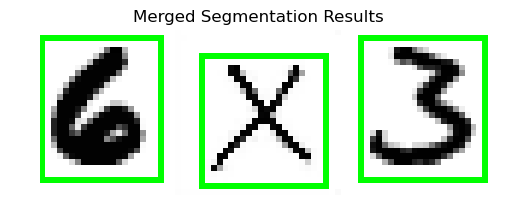

Segment #0: '6'
Segment #1: '*'
Segment #2: '3'
Reconstructed Expression: 6*3

Processing image: expression_dataset/expr_053.png


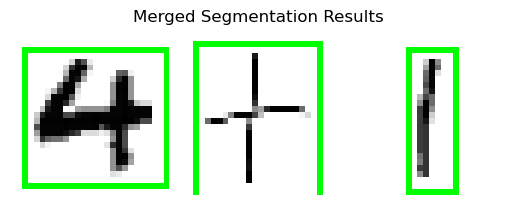

Segment #0: '4'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 4+1

Processing image: expression_dataset/expr_084.png


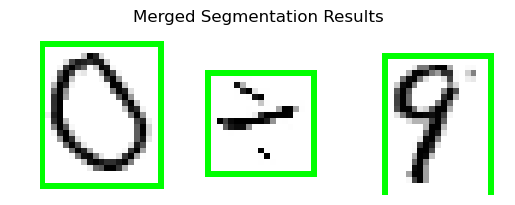

Segment #0: '0'
Segment #1: '/'
Segment #2: '8'
Reconstructed Expression: 0/8

Processing image: expression_dataset/expr_090.png


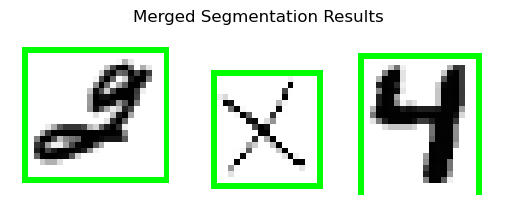

Segment #0: '2'
Segment #1: '*'
Segment #2: '4'
Reconstructed Expression: 2*4

Processing image: expression_dataset/expr_086.png


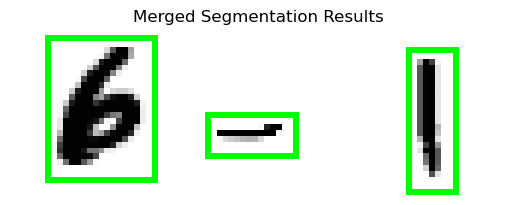

Segment #0: '6'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 6+1

Processing image: expression_dataset/expr_092.png


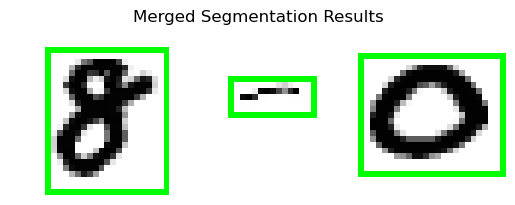

Segment #0: '8'
Segment #1: '/'
Segment #2: '0'
Reconstructed Expression: 8/0

Processing image: expression_dataset/expr_045.png


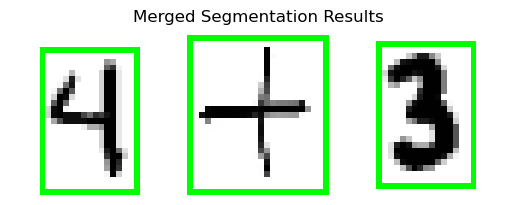

Segment #0: '4'
Segment #1: '+'
Segment #2: '3'
Reconstructed Expression: 4+3

Processing image: expression_dataset/expr_051.png


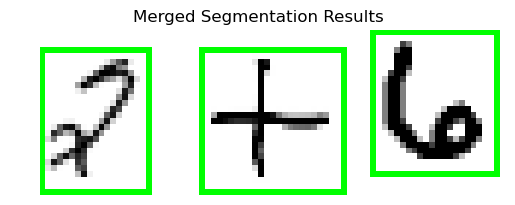

Segment #0: '2'
Segment #1: '+'
Segment #2: '6'
Reconstructed Expression: 2+6

Processing image: expression_dataset/expr_079.png


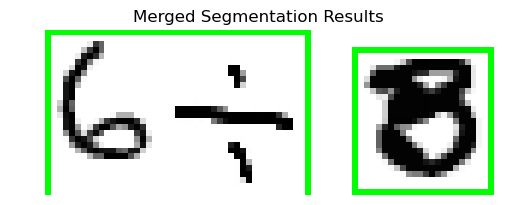

Segment #0: '4'
Segment #1: '/'
Reconstructed Expression: 4/

Processing image: expression_dataset/expr_078.png


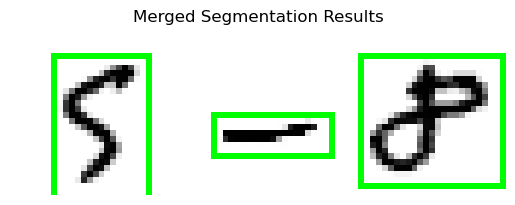

Segment #0: '5'
Segment #1: '+'
Segment #2: '8'
Reconstructed Expression: 5+8

Processing image: expression_dataset/expr_050.png


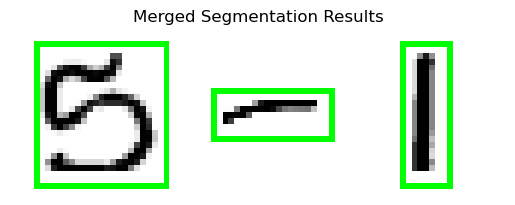

Segment #0: '5'
Segment #1: '*'
Segment #2: '1'
Reconstructed Expression: 5*1

Processing image: expression_dataset/expr_044.png


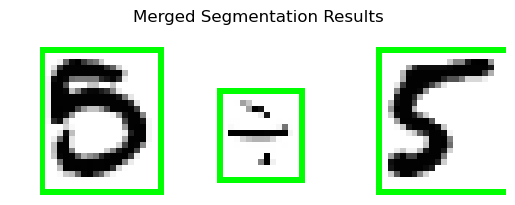

Segment #0: '5'
Segment #1: '/'
Segment #2: '5'
Reconstructed Expression: 5/5

Processing image: expression_dataset/expr_093.png


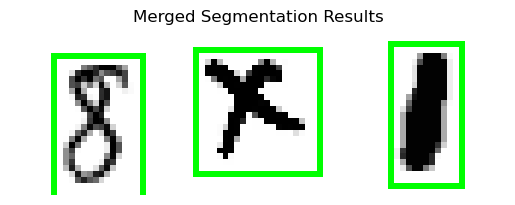

Segment #0: '5'
Segment #1: '*'
Segment #2: '1'
Reconstructed Expression: 5*1

Processing image: expression_dataset/expr_087.png


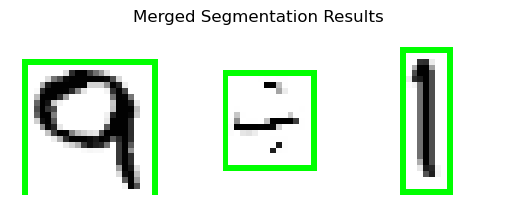

Segment #0: '8'
Segment #1: '/'
Segment #2: '1'
Reconstructed Expression: 8/1

Processing image: expression_dataset/expr_023.png


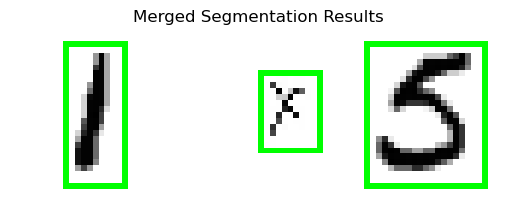

Segment #0: '1'
Segment #1: '*'
Segment #2: '5'
Reconstructed Expression: 1*5

Processing image: expression_dataset/expr_037.png


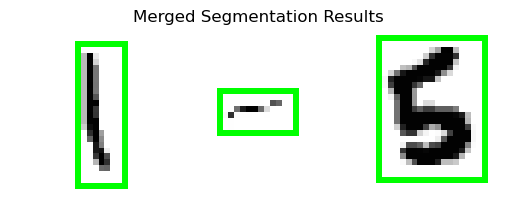

Segment #0: '1'
Segment #1: '+'
Segment #2: '5'
Reconstructed Expression: 1+5

Processing image: expression_dataset/expr_036.png


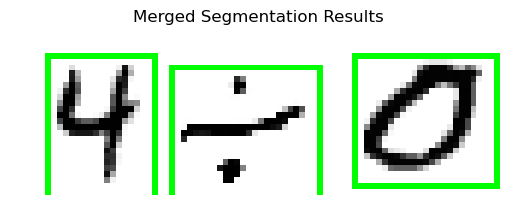

Segment #0: '4'
Segment #1: '/'
Segment #2: '0'
Reconstructed Expression: 4/0

Processing image: expression_dataset/expr_022.png


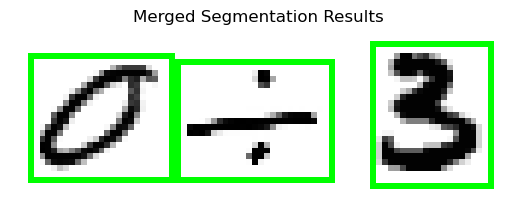

Segment #0: '0'
Segment #1: '/'
Segment #2: '3'
Reconstructed Expression: 0/3

Processing image: expression_dataset/expr_008.png


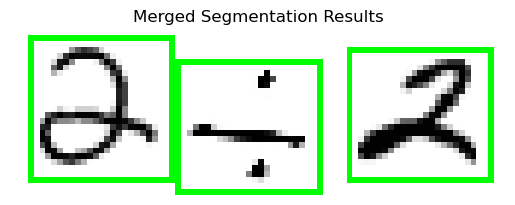

Segment #0: '2'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 2/2

Processing image: expression_dataset/expr_034.png


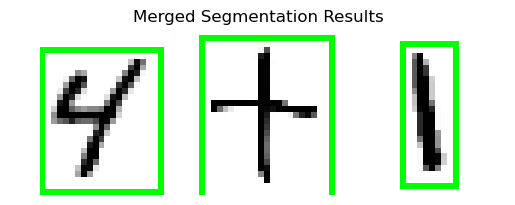

Segment #0: '4'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 4+1

Processing image: expression_dataset/expr_020.png


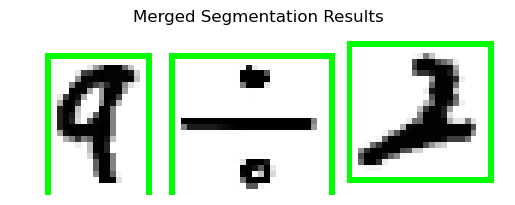

Segment #0: '8'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 8/2

Processing image: expression_dataset/expr_021.png


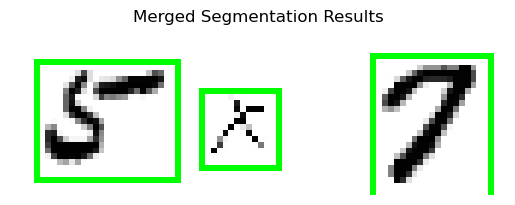

Segment #0: '5'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 5*2

Processing image: expression_dataset/expr_035.png


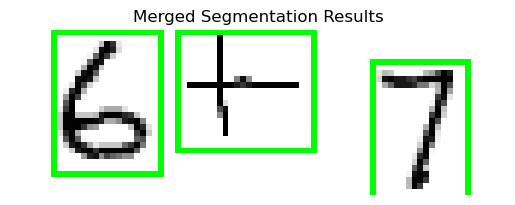

Segment #0: '6'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 6+2

Processing image: expression_dataset/expr_009.png


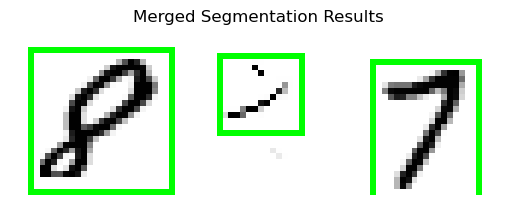

Segment #0: '8'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 8/2

Processing image: expression_dataset/expr_031.png


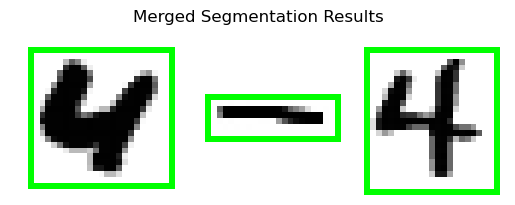

Segment #0: '4'
Segment #1: '*'
Segment #2: '4'
Reconstructed Expression: 4*4

Processing image: expression_dataset/expr_025.png


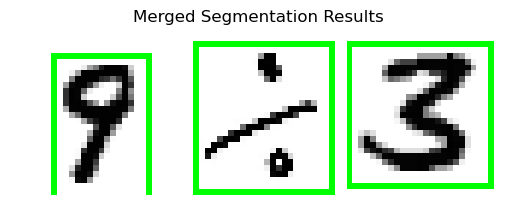

Segment #0: '8'
Segment #1: '/'
Segment #2: '3'
Reconstructed Expression: 8/3

Processing image: expression_dataset/expr_019.png


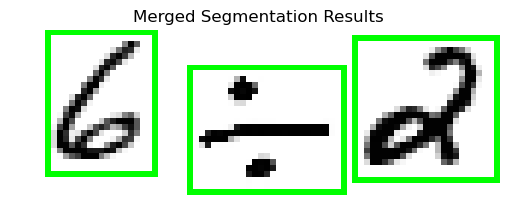

Segment #0: '6'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 6/2

Processing image: expression_dataset/expr_018.png


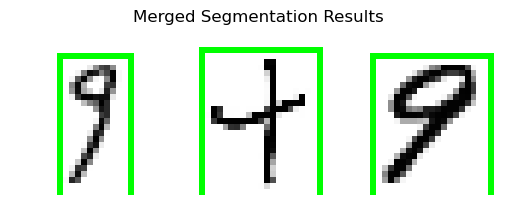

Segment #0: '1'
Segment #1: '+'
Segment #2: '8'
Reconstructed Expression: 1+8

Processing image: expression_dataset/expr_024.png


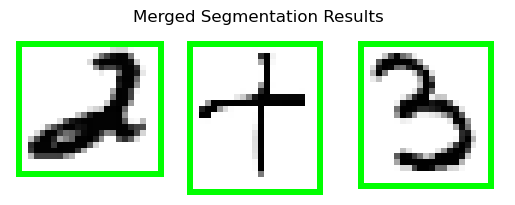

Segment #0: '2'
Segment #1: '+'
Segment #2: '3'
Reconstructed Expression: 2+3

Processing image: expression_dataset/expr_030.png


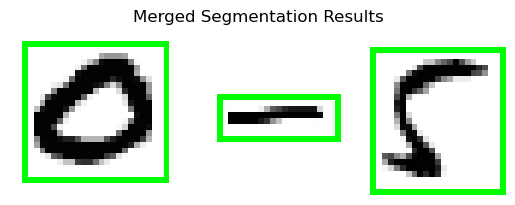

Segment #0: '0'
Segment #1: '/'
Segment #2: '0'
Reconstructed Expression: 0/0

Processing image: expression_dataset/expr_026.png


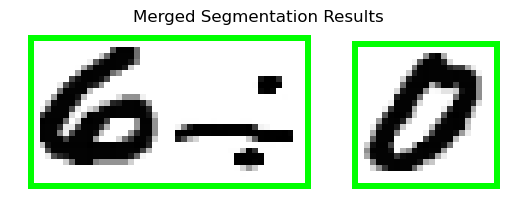

Segment #0: '4'
Segment #1: '/'
Reconstructed Expression: 4/

Processing image: expression_dataset/expr_032.png


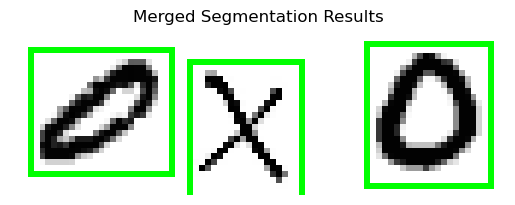

Segment #0: '0'
Segment #1: '*'
Segment #2: '0'
Reconstructed Expression: 0*0

Processing image: expression_dataset/expr_033.png


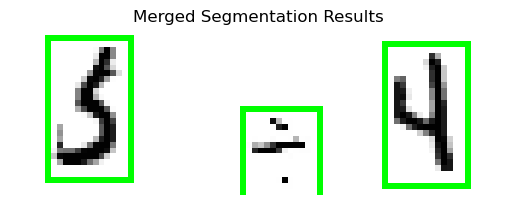

Segment #0: '3'
Segment #1: '+'
Segment #2: '4'
Reconstructed Expression: 3+4

Processing image: expression_dataset/expr_027.png


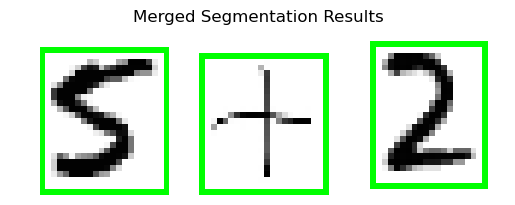

Segment #0: '5'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 5+2

Processing image: expression_dataset/expr_002.png


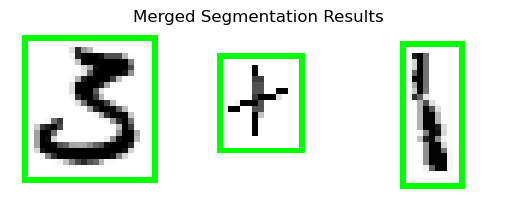

Segment #0: '3'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 3+1

Processing image: expression_dataset/expr_016.png


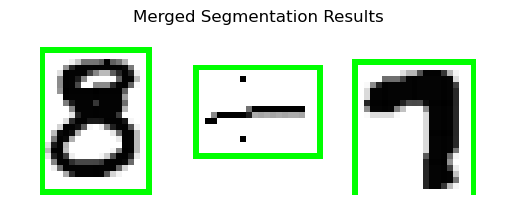

Segment #0: '8'
Segment #1: '/'
Segment #2: '2'
Reconstructed Expression: 8/2

Processing image: expression_dataset/expr_017.png


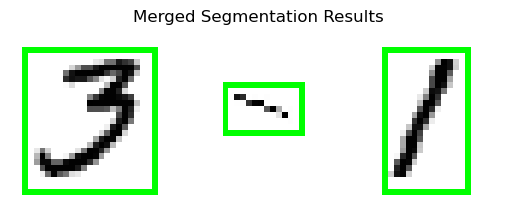

Segment #0: '3'
Segment #1: '*'
Segment #2: '1'
Reconstructed Expression: 3*1

Processing image: expression_dataset/expr_003.png


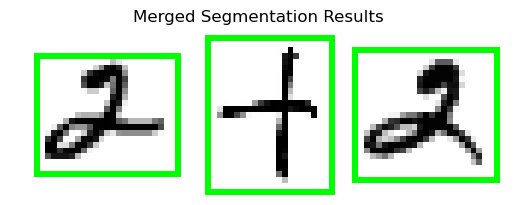

Segment #0: '2'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 2+2

Processing image: expression_dataset/expr_029.png


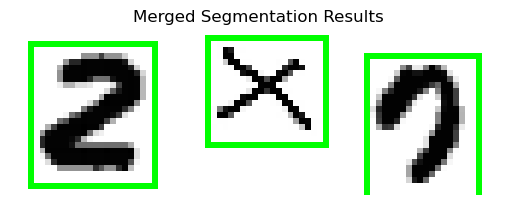

Segment #0: '2'
Segment #1: '*'
Segment #2: '9'
Reconstructed Expression: 2*9

Processing image: expression_dataset/expr_015.png


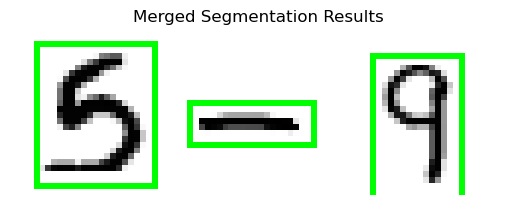

Segment #0: '5'
Segment #1: '+'
Segment #2: '4'
Reconstructed Expression: 5+4

Processing image: expression_dataset/expr_001.png


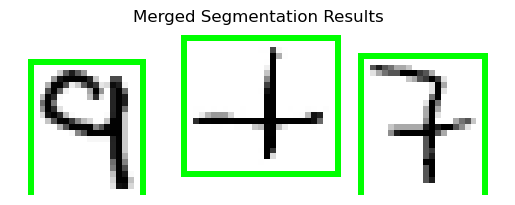

Segment #0: '5'
Segment #1: '+'
Segment #2: '3'
Reconstructed Expression: 5+3

Processing image: expression_dataset/expr_000.png


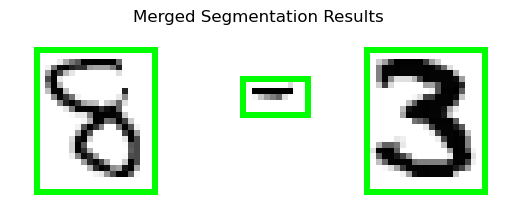

Segment #0: '8'
Segment #1: '*'
Segment #2: '3'
Reconstructed Expression: 8*3

Processing image: expression_dataset/expr_014.png


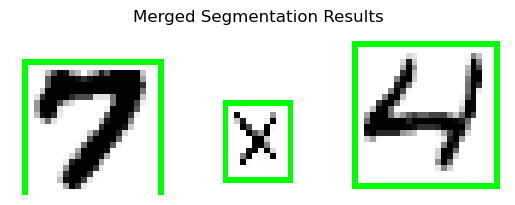

Segment #0: '2'
Segment #1: '*'
Segment #2: '4'
Reconstructed Expression: 2*4

Processing image: expression_dataset/expr_028.png


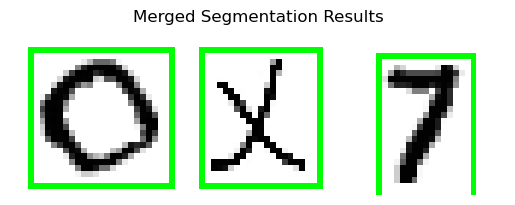

Segment #0: '0'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 0*2

Processing image: expression_dataset/expr_010.png


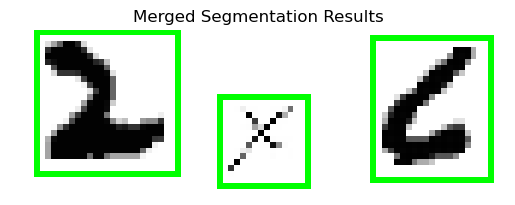

Segment #0: '2'
Segment #1: '*'
Segment #2: '0'
Reconstructed Expression: 2*0

Processing image: expression_dataset/expr_004.png


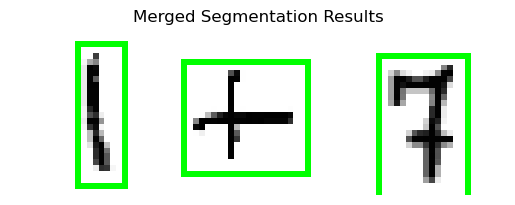

Segment #0: '1'
Segment #1: '+'
Segment #2: '7'
Reconstructed Expression: 1+7

Processing image: expression_dataset/expr_038.png


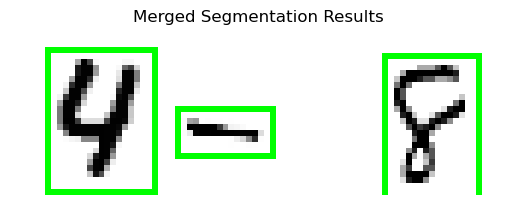

Segment #0: '4'
Segment #1: '+'
Segment #2: '8'
Reconstructed Expression: 4+8

Processing image: expression_dataset/expr_039.png


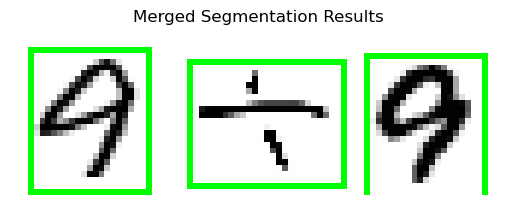

Segment #0: '4'
Segment #1: '/'
Segment #2: '9'
Reconstructed Expression: 4/9

Processing image: expression_dataset/expr_005.png


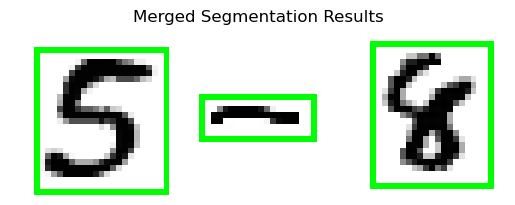

Segment #0: '5'
Segment #1: '/'
Segment #2: '8'
Reconstructed Expression: 5/8

Processing image: expression_dataset/expr_011.png


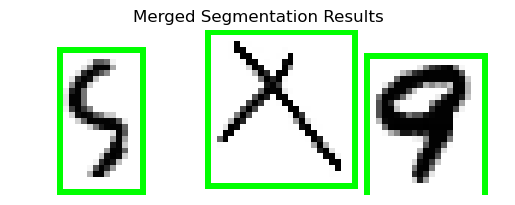

Segment #0: '5'
Segment #1: '*'
Segment #2: '9'
Reconstructed Expression: 5*9

Processing image: expression_dataset/expr_007.png


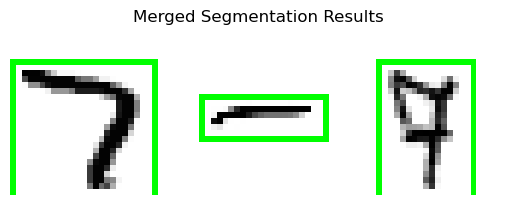

Segment #0: '2'
Segment #1: '+'
Segment #2: '9'
Reconstructed Expression: 2+9

Processing image: expression_dataset/expr_013.png


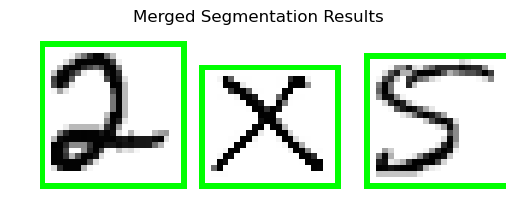

Segment #0: '2'
Segment #1: '*'
Segment #2: '5'
Reconstructed Expression: 2*5

Processing image: expression_dataset/expr_012.png


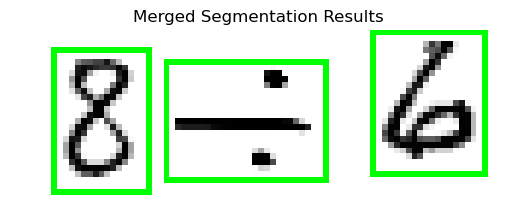

Segment #0: '8'
Segment #1: '/'
Segment #2: '6'
Reconstructed Expression: 8/6

Processing image: expression_dataset/expr_006.png


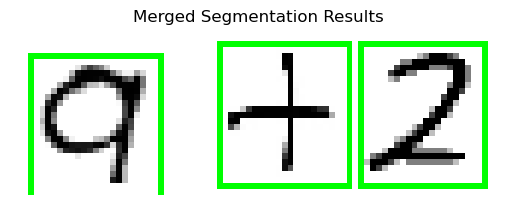

Segment #0: '2'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 2+2

Processing image: expression_dataset/expr_049.png


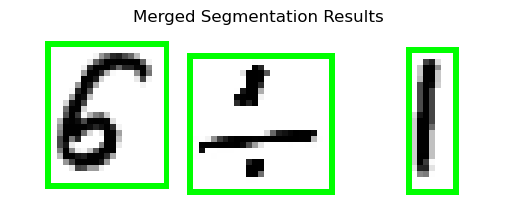

Segment #0: '5'
Segment #1: '/'
Segment #2: '1'
Reconstructed Expression: 5/1

Processing image: expression_dataset/expr_061.png


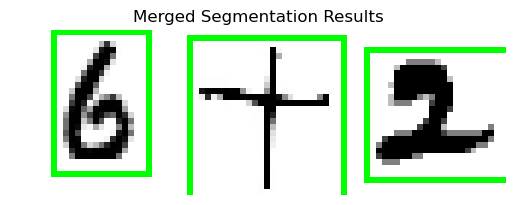

Segment #0: '6'
Segment #1: '+'
Segment #2: '2'
Reconstructed Expression: 6+2

Processing image: expression_dataset/expr_075.png


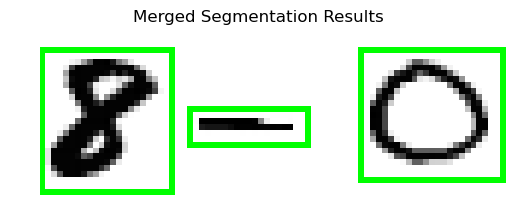

Segment #0: '8'
Segment #1: '/'
Segment #2: '0'
Reconstructed Expression: 8/0

Processing image: expression_dataset/expr_074.png


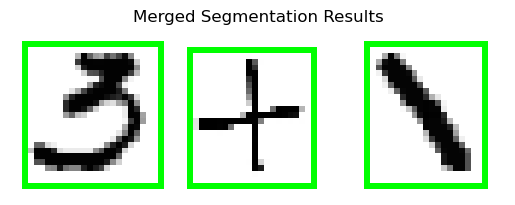

Segment #0: '3'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 3+1

Processing image: expression_dataset/expr_060.png


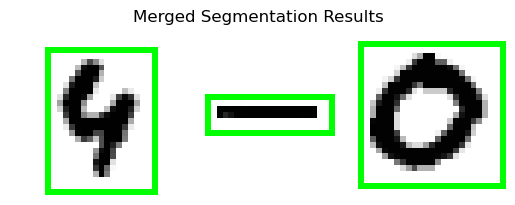

Segment #0: '4'
Segment #1: '+'
Segment #2: '0'
Reconstructed Expression: 4+0

Processing image: expression_dataset/expr_048.png


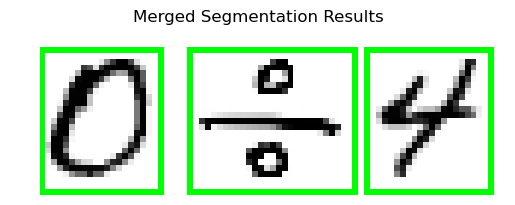

Segment #0: '0'
Segment #1: '/'
Segment #2: '4'
Reconstructed Expression: 0/4

Processing image: expression_dataset/expr_089.png


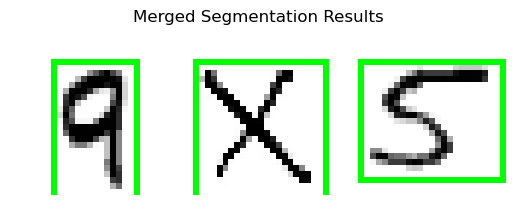

Segment #0: '9'
Segment #1: '*'
Segment #2: '5'
Reconstructed Expression: 9*5

Processing image: expression_dataset/expr_076.png


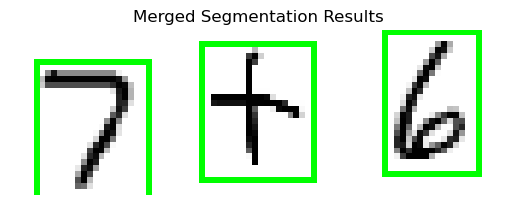

Segment #0: '2'
Segment #1: '+'
Segment #2: '6'
Reconstructed Expression: 2+6

Processing image: expression_dataset/expr_062.png


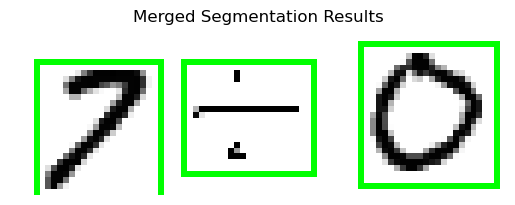

Segment #0: '2'
Segment #1: '/'
Segment #2: '0'
Reconstructed Expression: 2/0

Processing image: expression_dataset/expr_063.png


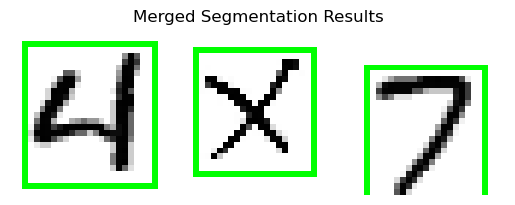

Segment #0: '4'
Segment #1: '*'
Segment #2: '2'
Reconstructed Expression: 4*2

Processing image: expression_dataset/expr_077.png


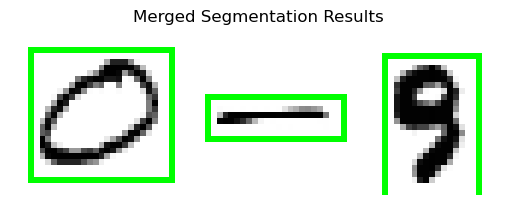

Segment #0: '0'
Segment #1: '+'
Segment #2: '9'
Reconstructed Expression: 0+9

Processing image: expression_dataset/expr_088.png


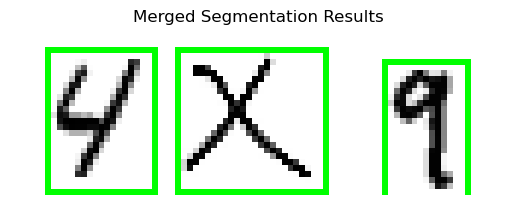

Segment #0: '4'
Segment #1: '*'
Segment #2: '3'
Reconstructed Expression: 4*3

Processing image: expression_dataset/expr_098.png


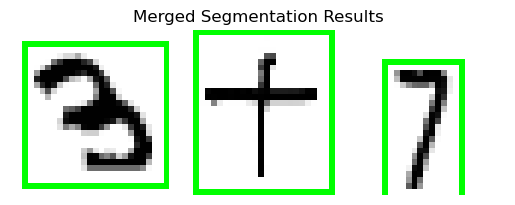

Segment #0: '3'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 3+1

Processing image: expression_dataset/expr_073.png


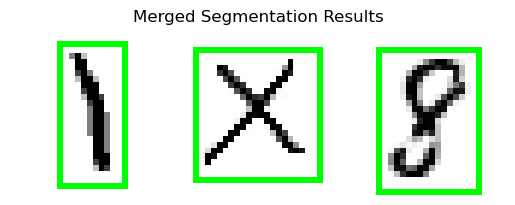

Segment #0: '1'
Segment #1: '*'
Segment #2: '8'
Reconstructed Expression: 1*8

Processing image: expression_dataset/expr_067.png


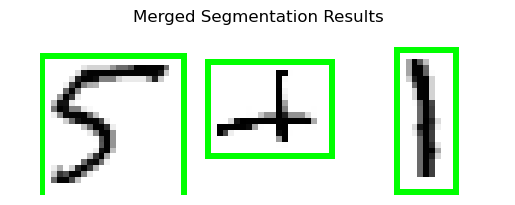

Segment #0: '5'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 5+1

Processing image: expression_dataset/expr_066.png


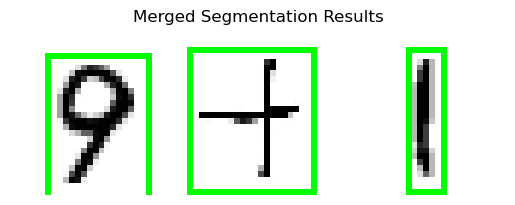

Segment #0: '8'
Segment #1: '+'
Segment #2: '1'
Reconstructed Expression: 8+1

Processing image: expression_dataset/expr_072.png


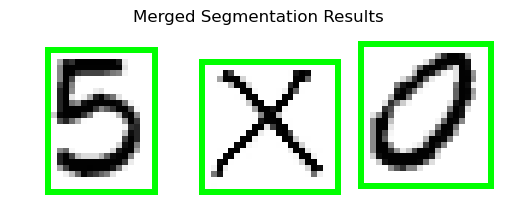

Segment #0: '5'
Segment #1: '*'
Segment #2: '0'
Reconstructed Expression: 5*0

Processing image: expression_dataset/expr_064.png


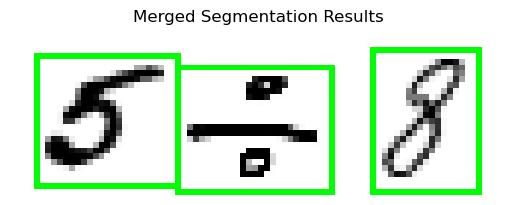

Segment #0: '5'
Segment #1: '/'
Segment #2: '8'
Reconstructed Expression: 5/8

Processing image: expression_dataset/expr_070.png


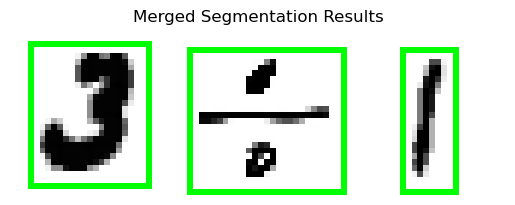

Segment #0: '3'
Segment #1: '/'
Segment #2: '1'
Reconstructed Expression: 3/1

Processing image: expression_dataset/expr_058.png


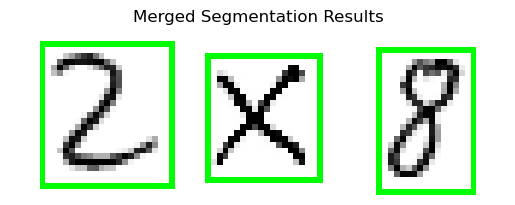

Segment #0: '2'
Segment #1: '*'
Segment #2: '8'
Reconstructed Expression: 2*8

Processing image: expression_dataset/expr_059.png


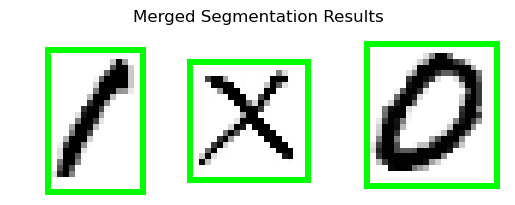

Segment #0: '1'
Segment #1: '*'
Segment #2: '0'
Reconstructed Expression: 1*0

Processing image: expression_dataset/expr_071.png


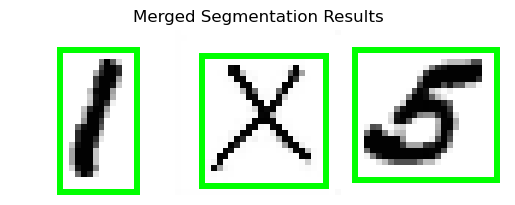

Segment #0: '1'
Segment #1: '*'
Segment #2: '5'
Reconstructed Expression: 1*5

Processing image: expression_dataset/expr_065.png


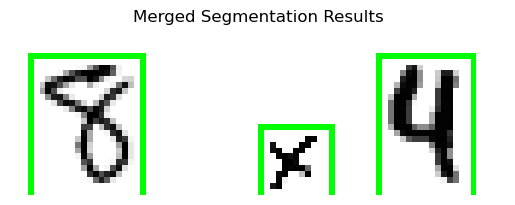

Segment #0: '8'
Segment #1: '*'
Segment #2: '4'
Reconstructed Expression: 8*4


In [31]:
digit_model = joblib.load('digit_model.joblib')
operator_model = joblib.load('operator_model.joblib')

expr_files = glob.glob(os.path.join("expression_dataset", "*.png"))
if not expr_files:
    print("No expression images found in the dataset folder.")

for expr_file in expr_files:
    print(f"\nProcessing image: {expr_file}")
    expr_str = process_expression(expr_file, digit_model, operator_model, debug=True)
    print("Reconstructed Expression:", expr_str)

In [33]:
csv_path = os.path.join("expression_dataset", "expression_labels.csv")

if not os.path.isfile(csv_path):
    print(f"CSV file not found at: {csv_path}")
else:
    df = pd.read_csv(csv_path)

    total = 0
    correct = 0

    print("\n--- Evaluating Expression Classification Accuracy ---")
    for idx, row in df.iterrows():
        fname = row['image']
        true_expr = row['true_expr']
        img_path = os.path.join("expression_dataset", fname)
        predicted_expr = process_expression(img_path, digit_model, operator_model, debug=False, flag=True)

        total += 1
        if predicted_expr == true_expr:
            correct += 1

    print(f"\nTotal: {total} | Correct: {correct} | Accuracy: {100 * correct / total:.2f}%")


--- Evaluating Expression Classification Accuracy ---

Total: 99 | Correct: 30 | Accuracy: 30.30%


In [35]:
csv_path = os.path.join("expression_dataset", "expression_labels.csv")   
df = pd.read_csv(csv_path)
digit_correct = 0
digit_total = 0
op_correct = 0
op_total = 0

digit_preds = []
op_preds = []

print("\n--- Evaluating on Segmented Items ---")
for idx, row in df.iterrows():
    fname = row['image']
    true_expr = row['true_expr']
    img_path = os.path.join("expression_dataset", fname)
    _, segments = segment_expression(img_path)

    for i, seg in enumerate(segments):
        if i >= len(true_expr):
            break

        true_char = true_expr[i]

        if true_char.isdigit():
            x_digit = preprocess_segment_for_digit(seg)
            pred = digit_model.predict([x_digit])[0]
            digit_preds.append((true_char, pred))
            digit_total += 1
            if int(true_char) == pred:
                digit_correct += 1

        elif true_char in ['+', '-', '*', '/']:
            x_op = preprocess_segment_for_operator(seg)
            pred = operator_model.predict([x_op])[0]
            op_mapping = {0: '+', 1: '-', 2: '*', 3: '/'}
            pred_symbol = op_mapping.get(pred, '?')
            op_preds.append((true_char, pred_symbol))
            op_total += 1
            if true_char == pred_symbol:
                op_correct += 1

print(f"\nDigit Accuracy: {digit_correct}/{digit_total} = {100 * digit_correct / digit_total:.2f}%")
print(f"Operator Accuracy: {op_correct}/{op_total} = {100 * op_correct / op_total:.2f}%")


--- Evaluating on Segmented Items ---

Digit Accuracy: 93/151 = 61.59%
Operator Accuracy: 53/93 = 56.99%
